## Dynamic Flux Based Analysis


In [9]:
from cobra.io import read_sbml_model
from dfba.plot.matplotlib import *
from dfba import DfbaModel, ExchangeFlux, KineticVariable

In [10]:
model = read_sbml_model('models/iMM904_progesterone.xml')

In [11]:
# max growth and max progesterone production
with model:
    baseline_max_growth = model.optimize().objective_value
    model.objective = model.reactions.DM_progesterone_c
    baseline_max_production = model.optimize().objective_value
print(f"Maximum growth: {baseline_max_growth} mmol/gDW*h")
print(f"Maximum progesterone production: {baseline_max_production} mmol/gDW*h")

with model:
# growth and progesterone production when both are set to be objective
    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    model.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone = solution.fluxes['DM_progesterone_c']
    print(f"Growth in complete model: {growth} mmol/gDW*h")
    print(f"Progesterone production in complete model: {progesterone} mmol/gDW*h")
model.reactions.DM_progesterone_c.lower_bound = progesterone * 1000 / 314.46

Maximum growth: 0.287865703704015 mmol/gDW*h
Maximum progesterone production: 0.16666666666666655 mmol/gDW*h
Growth in complete model: 0.11872292252086913 mmol/gDW*h
Progesterone production in complete model: 0.15620047742340093 mmol/gDW*h


In [12]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [14]:
# instances of KineticVariable
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Pro = KineticVariable("Progesterone")
# Oxy = KineticVariable("Oxygen")

# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Gluc, Pro])

In [15]:
# instances of ExchangeFlux

mu = ExchangeFlux("BIOMASS_SC5_notrace")
v_G = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("DM_progesterone_c")

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

In [16]:
# add rhs expressions for kinetic variables in dfba_model
#ENHEDER?
Vgmax = 8.5
Kg = 0.5
Gin = 100.0
Vomax = 8.0

#This is flux terms:
#dfba_model.add_rhs_expression("Volume", D)
#dfba_model.add_rhs_expression("Oxygen", 0) #keep O2 constant
dfba_model.add_rhs_expression("Biomass", mu * X )
dfba_model.add_rhs_expression("Glucose", v_G * X )#* 180.1559 / 1000 ) #+ D * (Gin - Gluc) / V
dfba_model.add_rhs_expression("Progesterone", v_P * X )#* 314.46 / 1000 ) # - D * Pro / V

In [17]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

Oxy = 2
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

In [43]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (g/L)
#IS THIS TRUE???

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05,
        "Glucose": 10.0,
        "Progesterone": 0
    }
)

In [44]:
# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting
# every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "DM_progesterone_c"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 31
Number of residual evaluations     = 102
Number of Jacobian evaluations     = 18
Number of nonlinear iterations     = 49
Number of error test failures      = 3
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 116


Final Run Statistics: 

Number of steps                    = 3
Number of residual evaluations     = 8
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 4
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 7


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluations     = 4
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 2
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 12


Final Run Statistics: 

Number of steps                    = 9
Number of residual evaluations

Text(0.5, 1.0, ' \n Batch fermentation in steady state\n')

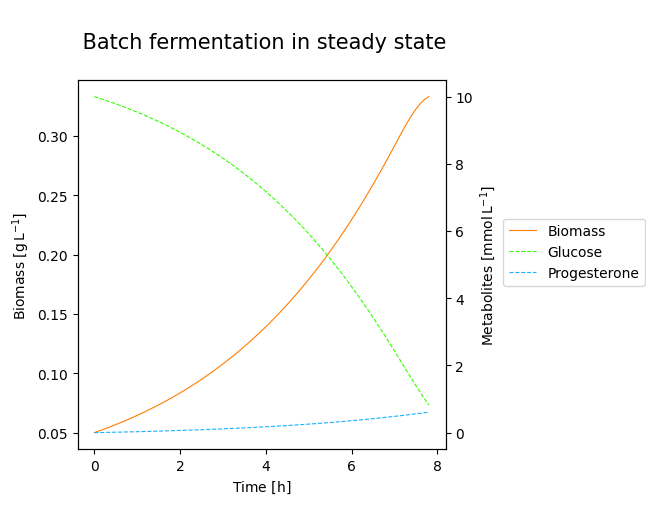

In [45]:
plot_concentrations(concentrations)
plt.title(" \n Batch fermentation in steady state\n", size=15)

In [21]:
concentrations

,time,Biomass,Glucose,Progesterone
0,0.0,0.050000,10.000000,0.000000
1,0.1,0.051292,9.959006,0.002516
2,0.2,0.052618,9.916956,0.005097
3,0.3,0.053978,9.873806,0.007746
4,0.4,0.055373,9.829555,0.010463
...,...,...,...,...
74,7.4,0.317491,1.596175,0.545177
75,7.5,0.322792,1.392362,0.561082
76,7.6,0.327324,1.193239,0.577231
77,7.7,0.330868,1.001210,0.593582


Text(0.5, 1.0, '\n Fluxes for batch fermentation in steady state \n')

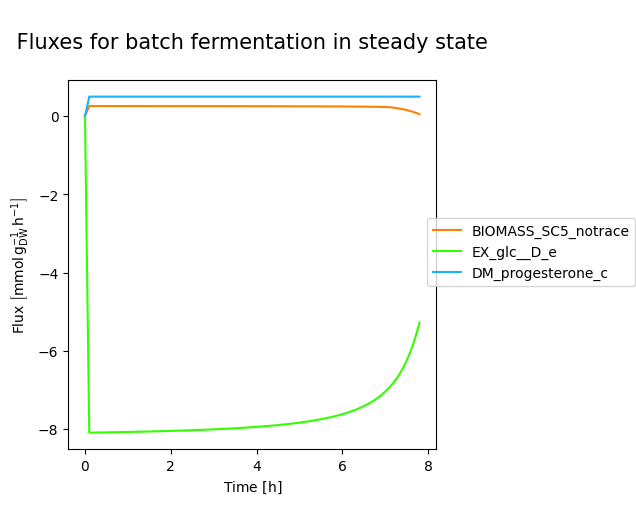

In [39]:
plot_trajectories(trajectories)
plt.title("\n Fluxes for batch fermentation in steady state \n", size=15)

In [23]:
trajectories

,time,BIOMASS_SC5_notrace,EX_glc__D_e,DM_progesterone_c
0,0.0,0.000000,0.000000,0.000000
1,0.1,0.255141,-8.093652,0.496726
2,0.2,0.255104,-8.092011,0.496726
3,0.3,0.255067,-8.090314,0.496726
4,0.4,0.255028,-8.088559,0.496726
...,...,...,...,...
74,7.4,0.177263,-6.472497,0.496726
75,7.5,0.153468,-6.254129,0.496726
76,7.6,0.124688,-5.990018,0.496726
77,7.7,0.089701,-5.668950,0.496726
